# Chapter7 TimeSeries

- 데이터가 시간의 흐름에 따라 변화하는 추이가 있는 데이터를 예측.
- 원 데이터의 안정성(stationary)을 판정하고, 안정한 형태로 변환하고, 예측 모델을 선정하고 검정.
- 전문적인 예측이 아닌 간단한 예측이라면, 유용한 도구인 fbpropher 모듈 소개
- 윈도우 유저들은 Visual C++ Build Tools를 설치해야함.
- 터미널에서 `pip install pystan`, `pip install prophet`을 수행해야함.

---
## 7-1 Numpy의 polyfit으로 회귀(regression)분석하기

한글폰트관련 코드

In [3]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [1]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


필요 모듈 불러오기

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet
from datetime import datetime

https://goo.gl/5wWzLL에서 08. PinkWink Web Traffic.csv 라는 데이터를 받아 data폴더에 저장합니다.

In [6]:
pinkwink_web = pd.read_csv('/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/08. PinkWink Web Traffic.csv',
                           encoding = 'utf-8', thousands = ',',
                           names = ['date', 'hit'], index_col=0)

pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


단순하게 2016년 7월 1일부터 2017년 6월 16일까지 유입량을 그려봅니다.

어떤 주기성이 있을 것 같은데, 시간순으로 되어있는 데이터를 그냥 봐서는 잘 모르겠습니다. 물론 유심히 보면 6개월의 주기성 정도는 육안으로 확인되기도 합니다.

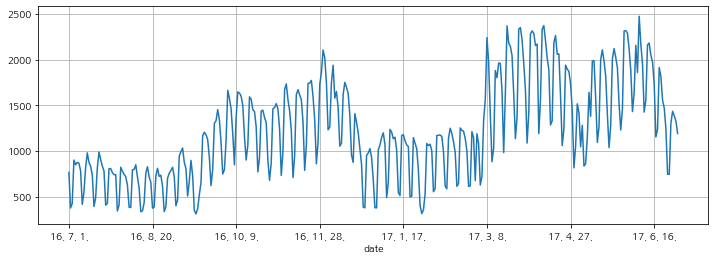

In [7]:
pinkwink_web['hit'].plot(figsize=(12,4), grid=True);

좀 더 정확한 주기성이 있다면 확인해 보고싶습니다.

먼저 시간출(time)을 만들고 웹 트래픽의 자료를 traffic변수에 저장합니다.

지금 우리는 위의 그래프를 설명할 간단한 함수를 찾으려고 합니다. 그게 직선일수도, 혹은 다항식으로 표현되는 곡선일 수도 있습니다. 어쨌든 데이터를 간단한 모델로 표현하고 싶다는 뜻입니다. 그런 작업을 보통 회귀(regression)라고 합니다. 그래서 모델을 1차, 2차, 3차, 15차 다항식으로 표현하고 그 결과를 확인하려고 합니다.

In [8]:
time = np.arange(0, len(pinkwink_web))
traffic = pinkwink_web['hit'].values
fx = np.linspace(0, time[-1], 1000)

어떤 데이터를 어떤 모델로 표현하려고 하면 그 모델의 적합성을 확인하는 과정이 필요합니다. 그러기 위해서는 참 값과 비교해서 에러(error)를 계산해야합니다. 그래서 함수를 정의합니다.

In [9]:
def error(f,x,y):
    return np.sqrt(np.mean((f(x)-y)**2))

이제 책 초반 CCTV 분석에서 사용했던 polyfit과 poly1d를 사용해서 함수로 표현할 수 있습니다. 그렇게 1차,2차,3차 에러를 확인합니다.

In [11]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

fp2 = np.polyfit(time, traffic, 2)
f2 = np.poly1d(fp2)

fp3 = np.polyfit(time, traffic, 3)
f3 = np.poly1d(fp3)

fp15 = np.polyfit(time, traffic, 15)
f15 = np.poly1d(fp15)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.8597308110963
430.6284101894695
429.53280466762925
330.47773021321143


이를 그래프로 표현해 보겠습니다.

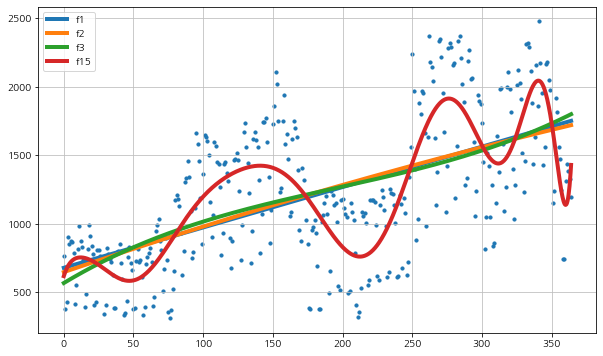

In [13]:
plt.figure(figsize = (10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label = 'f1')
plt.plot(fx, f2(fx), lw=4, label = 'f2')
plt.plot(fx, f3(fx), lw=4, label = 'f3')
plt.plot(fx, f15(fx), lw=4, label = 'f15')

plt.grid(True, linestyle = '-', color='0.75')

plt.legend(loc=2)
plt.show()

데이터를 1,2,3,15차 함수로 표현한 그래프 입니다. 1차 2차 3차가 정의된 함수에서 에러를 확인해보니 왜 큰 차이가 없는지 알겠습니다. 결국 2차나 3차로 표현하려면 그냥 1차로 표현하는 것이 차라리 나아보입니다. 그렇다고 15차 함수를 사용해서 표현하는 것은 과적합(over-fitting) 일 수 있습니다. 어떤 모델을 선택할지는 결국 분석하는 사람의 몫입니다. 그러나 위의 그래프 만으로는 어떤 결론을 내려야할지 모르겠습니다. 우리는 앞으로의 데이터도 예측하고 싶기 때문입니다.

## 7-2 Prophet 모듈을 이용한 forecast 예측